In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import numpy as np
from typing import Optional

In [22]:
def drop_path_f(x, drop_prob: float = 0., training: bool = False):

    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

In [23]:
class DropPath(nn.Module):

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path_f(x, self.drop_prob, self.training)

In [24]:
def window_partition(x, window_size: int):
    B, H, W, C = x.shape
    # x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    x = x.view(B, H, W // window_size, window_size, C)  # [B, H, W//Mh, Mw, C]
    # permute: [B, H//Mh, Mh, W//Mw, Mw, C] -> [B, H//Mh, W//Mh, Mw, Mw, C]
    # view: [B, H//Mh, W//Mw, Mh, Mw, C] -> [B*num_windows, Mh, Mw, C]
    # windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    windows = x.permute(0, 2, 1, 3, 4).contiguous().view(-1, window_size, C)
    return windows


def window_reverse(windows, window_size: int, H: int, W: int):
    # B = int(windows.shape[0] / (H * W / window_size / window_size))
    B = int(windows.shape[0] / (H * W / window_size))
    # view: [B*num_windows, Mh, Mw, C] -> [B, H//Mh, W//Mw, Mh, Mw, C]
    x = windows.view(B, H, W // window_size, window_size, -1)
    # permute: [B, H//Mh, W//Mw, Mh, Mw, C] -> [B, H//Mh, Mh, W//Mw, Mw, C]
    # view: [B, H//Mh, Mh, W//Mw, Mw, C] -> [B, H, W, C]
    # x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    x = x.view(B, H, W, -1)

    return x

In [34]:
data = torch.randn(5,1,500,30)
ws = window_partition(data, window_size=4)
print(ws.shape)
x = window_reverse(windows=ws, window_size=4, H=1, W=500)
print(x.shape)

torch.Size([625, 4, 30])
torch.Size([5, 1, 500, 30])


In [58]:
class PatchEmbed(nn.Module):
    def __init__(self, patch_size=4, in_c=30, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = (1, patch_size)  # 假设我们对单通道（时间序列）数据进行处理
        self.patch_size = patch_size
        self.in_chans = in_c
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size[1])
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        _, _, H, W = x.shape
        pad_input = (W % self.patch_size[1] != 0)
        if pad_input:
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1],
                          0, 0,
                          0, 0))

        x = x.float()
        x = self.proj(x)  # 使用卷积操作将每个patch映射到嵌入空间
        _, _, H, W = x.shape
        print(x.shape)
        x = x.flatten(2).transpose(1, 2)
        print(x.shape)
        x = self.norm(x)
        return x, H, W


input：(Batch_nums, in_chans, 1, time_datas) (batch, 30, 1, 500)
output: (Batch_nums, patch_nums, embed_dim)  (batch, 125, 96) # 每个patch包含通道信息和时间信息

In [60]:
PE = PatchEmbed()
data = torch.randn(10, 30, 1, 500)
outdata = PE(data)
print(outdata[0].shape)

torch.Size([10, 96, 1, 125])
torch.Size([10, 125, 96])
torch.Size([10, 125, 96])


In [63]:
class PatchMerging(nn.Module):
 
    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(2 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(2 * dim)

    def forward(self, x, H=1, W=125):
        """
        x: B, H*W, C
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        pad_input = (W % 2 == 1)
        if pad_input:
              x = F.pad(x, (0, 0, 0, W % 2, 0, 0))

        x0 = x[:, :, 0::2, :]  # [B, H, W/2, C]
        x1 = x[:, :, 1::2, :]  # [B, H, W/2, C]
        print(x1.shape)
        x = torch.cat([x0, x1], -1)  # [B, H, W/2, 2*C]
        print(x.shape)
        x = x.view(B, -1, 2 * C)  # [B, H/2*W/2, 2*C]
        # print(x[0][0][1:10])
        x = self.norm(x)
        # print(x[0][0][1:10])
        x = self.reduction(x)  # [B, H*W/2, 2*C]
        # print(x[0][0][1:10])
        return x

PatchMerging 将相邻patch在channel维度上合并。结果是patch减半，特征维度翻倍

In [64]:
PM = PatchMerging(dim=96)
outdata2 = PM(outdata[0])
print(outdata2.shape)

torch.Size([10, 1, 63, 96])
torch.Size([10, 1, 63, 192])
torch.Size([10, 63, 192])


In [45]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        print(x[0][0][1:10])
        x = self.act(x)
        print(x[0][0][1:10])
        x = self.drop1(x)
        print(x[0][0][1:10])
        x = self.fc2(x)
        print(x[0][0][1:10])
        x = self.drop2(x)
        print(x[0][0][1:10])
        return x

In [57]:
MLP = Mlp(in_features=192,hidden_features=1024,out_features=192, drop=0.5)
output = MLP(outdata)
print(output.shape)

tensor([ 0.1763, -0.2487,  0.0013, -0.3459,  0.2730, -0.4266, -0.2139, -0.4137,
         0.0055], grad_fn=<SliceBackward0>)
tensor([ 0.1005, -0.0999,  0.0007, -0.1261,  0.1659, -0.1428, -0.0888, -0.1405,
         0.0028], grad_fn=<SliceBackward0>)
tensor([ 0.0000, -0.0000,  0.0013, -0.2523,  0.0000, -0.0000, -0.0000, -0.0000,
         0.0000], grad_fn=<SliceBackward0>)
tensor([ 0.2095,  0.0346,  0.3192,  0.0152, -0.3008, -0.1014, -0.0806,  0.1333,
        -0.0806], grad_fn=<SliceBackward0>)
tensor([0.0000, 0.0692, 0.6384, 0.0303, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000],
       grad_fn=<SliceBackward0>)
torch.Size([10, 63, 192])


In [81]:
class WindowAttention(nn.Module):
 
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # [Mh, Mw]
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # [2*Mh-1 * 2*Mw-1, nH]

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        # coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))  # [2, Mh, Mw]
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # [2, Mh, Mw]
        coords_flatten = torch.flatten(coords, 1)  # [2, Mh*Mw]
   
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # [2, Mh*Mw, Mh*Mw]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # [Mh*Mw, Mh*Mw, 2]
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # [Mh*Mw, Mh*Mw]
        self.register_buffer("relative_position_index", relative_position_index)

        # print(relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        """
        Args:
            x: input features with shape of (num_windows*B, Mh*Mw, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        # [batch_size*num_windows, Mh*Mw, total_embed_dim]
        B_, N, C = x.shape
        # qkv(): -> [batch_size*num_windows, Mh*Mw, 3 * total_embed_dim]
        # reshape: -> [batch_size*num_windows, Mh*Mw, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size*num_windows, num_heads, Mh*Mw, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size*num_windows, num_heads, Mh*Mw, embed_dim_per_head]
        q, k, v = qkv.unbind(0)  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        print(attn.shape)
        print(self.relative_position_bias_table.shape)
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # [nH, Mh*Mw, Mh*Mw]
        print(relative_position_bias.shape)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            # mask: [nW, Mh*Mw, Mh*Mw]
            nW = mask.shape[0]  # num_windows
            # attn.view: [batch_size, num_windows, num_heads, Mh*Mw, Mh*Mw]
            # mask.unsqueeze: [1, nW, 1, Mh*Mw, Mh*Mw]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

先进行window_partition（输入[batch_nums, 1, patch_nums, dim_nums], 输出[batch_nums*windows_nums， window_size, dim_nums]）,
 
再进行windowAttenion(输入[batch_nums*windows_nums， window_size, dim_nums]，输出[batch_nums*windows_nums， window_size, dim_nums])。

In [86]:
WA = WindowAttention(dim=192, window_size=(1,3), num_heads=2)
output = output.squeeze(1)
print(output.shape)
windowinput = window_partition(output,window_size=3)
print(windowinput.shape)
output2 = WA(windowinput)
print(output2.shape)

torch.Size([10, 1, 63, 192])
torch.Size([210, 3, 192])
torch.Size([210, 2, 3, 3])
torch.Size([5, 2])
torch.Size([2, 3, 3])
torch.Size([210, 3, 192])


In [28]:

class SwinTransformerBlock(nn.Module):


    def __init__(self, dim, num_heads, window_size=12, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=(1, self.window_size), num_heads=num_heads, qkv_bias=qkv_bias,
            attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, attn_mask):
        H, W = self.H, self.W
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        # pad_b = (self.window_size - H % self.window_size) % self.window_size
        pad_b = 0
        x = F.pad(x, (0, 0, pad_l, pad_r, 0, 0))
        _, Hp, Wp, _ = x.shape

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(0, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
            attn_mask = None

        x_windows = window_partition(shifted_x, self.window_size)  # [nW*B, Mh, Mw, C]
        x_windows = x_windows.view(-1, self.window_size, C)  # [nW*B, Mw, C]

        attn_windows = self.attn(x_windows, mask=attn_mask)  # [nW*B, Mh*Mw, C]

        attn_windows = attn_windows.view(-1, 1, self.window_size, C)  # [nW*B, Mh, Mw, C]
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # [B, H', W', C]

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(0, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :, :W, :].contiguous()

        x = x.view(B, H * W, C)

        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

In [29]:
SWBlock = SwinTransformerBlock(dim=96, num_heads=2)
Res = SWBlock(outdata[0])

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TypeError: forward() missing 1 required positional argument: 'attn_mask'

In [30]:
class BasicLayer(nn.Module):

    def __init__(self, dim, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        self.use_checkpoint = use_checkpoint
        self.shift_size = window_size // 2

        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else self.shift_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def create_mask(self, x, H, W):

        Hp = 1
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # [1, Hp, Wp, 1]

        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        # for h in h_slices:
        #     for w in w_slices:
        #         img_mask[:, h, w, :] = cnt
        #         cnt += 1
        for w in w_slices:
            img_mask[:, :, w, :] = cnt
            cnt += 1
       

        mask_windows = window_partition(img_mask, self.window_size)  # [nW, Mw, 1]
        mask_windows = mask_windows.view(-1, self.window_size)  # [nW, Mh*Mw]
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)  # [nW, 1, Mh*Mw] - [nW, Mh*Mw, 1]
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        return attn_mask

    def forward(self, x, H, W):
        attn_mask = self.create_mask(x, H, W)  # [nW, Mh*Mw, Mh*Mw]
        for blk in self.blocks:
            blk.H, blk.W = H, W
            if not torch.jit.is_scripting() and self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)
            else:
                x = blk(x, attn_mask)
        if self.downsample is not None:
            x = self.downsample(x, H, W)
            H, W = H, (W + 1) // 2

        return x, H, W

In [31]:
class SwinTransformer(nn.Module):

    def __init__(self, patch_size=4, in_chans=30, num_classes=1000,
                 embed_dim=96, depths=(2, 2, 6, 2), num_heads=(3, 6, 12, 24),
                 window_size=6, eeg_channel=30, num_eegsample=384, down_channel=16, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            patch_size=patch_size, in_c=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layers = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                depth=depths[i_layer],
                                num_heads=num_heads[i_layer],
                                window_size=window_size,
                                mlp_ratio=self.mlp_ratio,
                                qkv_bias=qkv_bias,
                                drop=drop_rate,
                                attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                                norm_layer=norm_layer,
                                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                                use_checkpoint=use_checkpoint)
            self.layers.append(layers)
        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # x: [B, L, C]    

        # x = self.dtDW(x)
        # x = self.dtCONV(x)
        # x = self.dtFC(x)
        # x = self.dtMulFC(x)

        x, H, W = self.patch_embed(x)
        x = self.pos_drop(x)
        for layer in self.layers:
            x, H, W = layer(x, H, W)

        x = self.norm(x)  # [B, L, C]
        x = self.avgpool(x.transpose(1, 2))  # [B, C, 1]
        x0 = torch.flatten(x, 1)
        x = self.head(x0)
        return x


def swin_eeg(window_size: int = 2, num_classes: int = 2, **kwargs):
    model = SwinTransformer(in_chans=30,
                            patch_size=4,
                            window_size=window_size,
                            embed_dim=192,
                            depths=(2, 2, 6, 2),
                            num_heads=(3, 6, 12, 24),
                            num_classes=num_classes,
                            **kwargs)
    return model



In [88]:
import numpy as np
import mne
from sklearn.decomposition import PCA
from mne.preprocessing import ICA

# 模拟 EEG 数据 (1, 30, 500)
samples = 1
channels = 30
time_points = 500
eeg_data = np.random.randn(samples, channels, time_points)  # 随机生成模拟 EEG 信号
print(f"rawdata, shape: {eeg_data.shape}")

# 转换为 MNE RawArray 格式
sfreq = 200  # 假设采样率为 200 Hz
info = mne.create_info(ch_names=[f"ch{i}" for i in range(channels)], sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(eeg_data[0], info)  # 创建 RawArray

# PCA 降维
n_components_pca = 10  # 目标主成分数
pca = PCA(n_components=n_components_pca)
reshaped_data = raw.get_data().T  # 获取数据并转置为 (时间点, 通道)
print(f"reshaped_data, shape: {reshaped_data.shape}")
pca_data = pca.fit_transform(reshaped_data)  # 结果 (500, 10)
pca_raw = mne.io.RawArray(pca_data.T, mne.create_info(ch_names=[f"PC{i}" for i in range(n_components_pca)], sfreq=sfreq))

print(f"After PCA, shape: {pca_data.shape}")  # 输出: (10, 500)

# ICA 提取独立成分
ica = ICA(n_components=n_components_pca, random_state=42)
ica.fit(pca_raw)  # 输入为 MNE 格式的 Raw
ica_data = ica.get_sources(pca_raw).get_data()  # 提取独立成分, 形状 (10, 500)

# 信号重建
reconstructed_raw = ica.apply(pca_raw)  # 修正伪迹后的 Raw 数据
reconstructed_data = reconstructed_raw.get_data()  # 转换为 NumPy 数组

# 还原到原始通道数
reconstructed_original = pca.inverse_transform(reconstructed_data.T).T  # 恢复到原始通道数
reconstructed_original = reconstructed_original.reshape(samples, channels, time_points)

print(f"Original shape: {eeg_data.shape}")
print(f"Reconstructed shape: {reconstructed_original.shape}")

rawdata, shape: (1, 30, 500)
Creating RawArray with float64 data, n_channels=30, n_times=500
    Range : 0 ... 499 =      0.000 ...     2.495 secs
Ready.
reshaped_data, shape: (500, 30)
Creating RawArray with float64 data, n_channels=10, n_times=500
    Range : 0 ... 499 =      0.000 ...     2.495 secs
Ready.
After PCA, shape: (500, 10)


/tmp/ipykernel_364289/1891628095.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(pca_raw)  # 输入为 MNE 格式的 Raw


ValueError: picks (NoneNone, treated as "data") yielded no channels, consider passing picks explicitly

dict_keys(['__header__', '__version__', '__globals__', 'eeg'])
(33, 1000)
Creating RawArray with float64 data, n_channels=33, n_times=1000
    Range : 0 ... 999 =      0.000 ...     1.998 secs
Ready.


<Figure size 5000x2000 with 0 Axes>

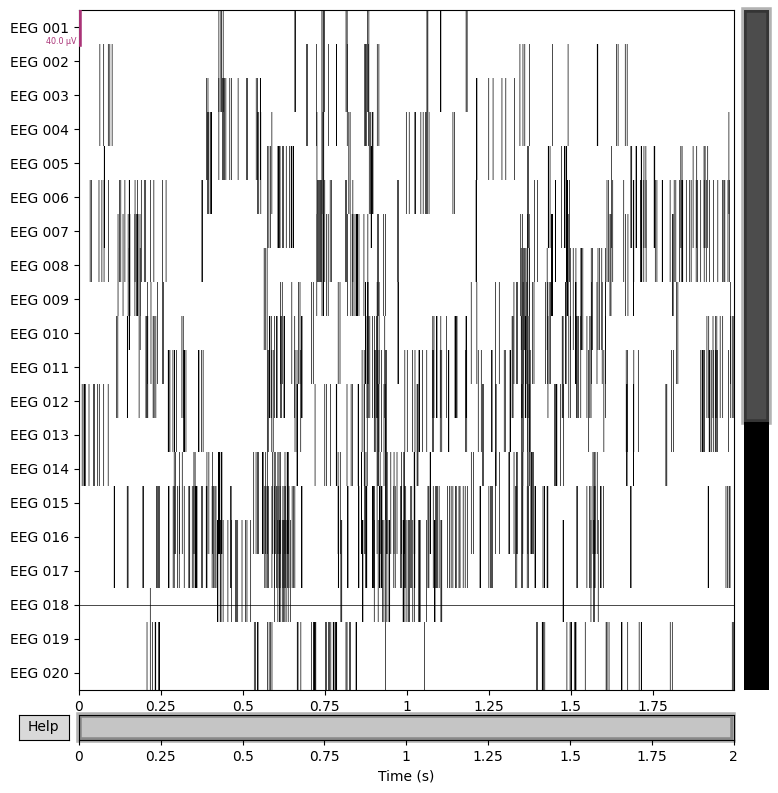

Overwriting existing file.
Writing /root/autodl-tmp/.autodl/kinlaw/mi_swin/converted_data.fif
Closing /root/autodl-tmp/.autodl/kinlaw/mi_swin/converted_data.fif
[done]


/tmp/ipykernel_364289/3932256620.py:24: RuntimeWarning: This filename (/root/autodl-tmp/.autodl/kinlaw/mi_swin/converted_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save("converted_data.fif", overwrite=True)


In [114]:
from scipy.io import loadmat
import mne
import numpy as np
import matplotlib.pyplot as plt
# Step 1: 读取 .mat 文件
data = loadmat("./subdataset/sourcedata/sub-50/sub-50_task-motor-imagery_eeg.mat")
print(data.keys())
# Step 2: 提取关键数据
eeg_data = data["eeg"]["rawdata"]  # (通道数, 时间点数)
eeg_data = eeg_data[0][0][0][:,0:1000]
sfreq = float(500)  # 采样率
print(eeg_data.shape)
n_channels = eeg_data.shape[0]  # 通道数
channel_names = [f"EEG {i+1:03d}" for i in range(n_channels)]  # 生成通道名称列表

# Step 3: 转换为 MNE 的 RawArray
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(data=eeg_data, info=info)
plt.figure(figsize=(50, 20))  # 宽 12 英寸，高 8 英寸
# Step 4: 可视化信号
raw.plot()

# Step 5: 保存为 FIF 格式
raw.save("converted_data.fif", overwrite=True)


In [98]:
print(eeg_data[0][0].shape)

(40, 33, 4000)
